***Modélisation par série temporelle***

In [4]:
import fonctions as f

In [6]:
# 1. Charger les données
df = f.pd.read_csv("df_with_missing.csv")
df.head()

,RR,TN,HTN,TX,HTX,TM,TMNX,DG,TAMPLI,TNTXM,...,UX,HUX,DHUMI40,DHUMI80,TSVM,UM,ETPGRILLE,NEIGETOTX,NEIGETOT06,DATE
0,2.6,-0.4,1759.0,3.4,1217.0,0.9,1.50,389.0,3.8,1.5,...,99.0,329.0,0.0,1157.0,5.7,88.0,0.4,0.0,0.0,20220105.0
1,0.0,-2.5,1746.0,4.3,1327.0,-0.6,0.90,964.0,6.8,0.9,...,99.0,2304.0,0.0,1043.0,5.1,88.0,0.6,0.0,0.0,20220106.0
2,10.0,-6.9,718.0,1.6,2229.0,-1.2,-2.65,674.0,8.5,-2.7,...,99.0,126.0,0.0,1440.0,5.4,96.0,0.0,0.0,0.0,20220107.0
3,13.2,-0.7,733.0,6.3,2319.0,2.4,2.80,87.0,7.0,2.8,...,99.0,618.0,0.0,1231.0,6.4,89.0,0.5,0.0,0.0,20220108.0
4,7.6,0.4,737.0,2.2,601.0,1.8,1.30,0.0,1.8,1.3,...,98.0,745.0,0.0,1440.0,6.5,94.0,0.1,0.0,0.0,20220109.0


In [ ]:
#Création de la variable "event":

# Définir les seuils arbitraires!
seuil_chaleur = 40  
seuil_froid = -5  
seuil_inondation = 50
seuil_tempete = 30


# Créer une variable "event"
df_cleadfned["event"] = ((df["TX"] > seuil_chaleur) | 
                        (df["TN"] < seuil_froid) |
                        (df["RR"] > seuil_inondation) |
                        (df["FXI"] > seuil_tempete)).astype(int)

# Afficher le DataFrame
df.head()

Choisir les variables cibles en fonction de leurs correlations avec la variable cible "Température Moyenne".

In [7]:
# Sélectionner les colonnes pertinentes pour la prédiction de TM (Température Moyenne)
variables_utiles = [ "ETPGRILLE", "TSVM", "TNTXM", "TMNX",  "TN", "TX"]
cible = "TM"  # Variable cible : Température Moyenne

In [ ]:
# Garder uniquement les colonnes utiles + la cible
df_mod = df_mod[variables_utiles + [cible]]

In [ ]:
# 3. Diviser les données en ensembles d'entraînement et de test
X = df_mod[variables_utiles]  # Variables explicatives
y = df_mod[cible]  # Variable cible

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# 4. Entraîner un modèle de prédiction (Random Forest)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [14]:
# 5. Faire des prédictions
y_pred = model.predict(X_test)

In [15]:
# 6. Évaluer les performances du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE) : {mse:.2f}")
print(f"R² Score : {r2:.2f}")


Mean Squared Error (MSE) : 0.82
R² Score : 0.98


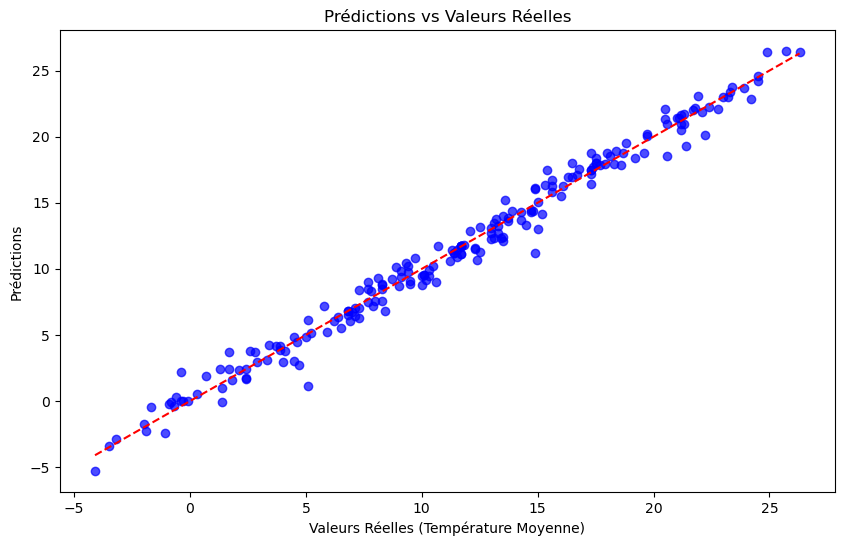

In [16]:
# 7. Visualiser les résultats
f.plt.figure(figsize=(10, 6))
f.plt.scatter(y_test, y_pred, alpha=0.7, color="blue")
f.plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], "--", color="red")
f.plt.title("Prédictions vs Valeurs Réelles")
f.plt.xlabel("Valeurs Réelles (Température Moyenne)")
f.plt.ylabel("Prédictions")
f.plt.show()

In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [18]:
# Convertir la colonne DATE en type datetime et définir comme index
df["DATE"] = pd.to_datetime(df["DATE"])
df.set_index("DATE", inplace=True)

In [19]:
# Garder uniquement la colonne cible TM
data = df["TM"]

In [22]:
# 2. Vérifier la stationnarité
result = adfuller(data)
print(f"Statistique de test ADF : {result[0]}")
print(f"p-value : {result[1]}")

if result[1] > 0.05:
    print("La série n'est pas stationnaire. Appliquer une différenciation.")
    data_diff = data.diff().dropna()  # Appliquer une différenciation
else:
    print("La série est stationnaire.")
    data_diff = data

Statistique de test ADF : -3.525958069197169
p-value : 0.007344931921113173
La série est stationnaire.


On a:
p-value<1%:
Les résultats statistiques ne nous permettre pas d'accepter l'hypothèse nulle selon laquelle TM n'est pas stationnaire au seuil de 1%. On rejette l'hypothèse nulle de non-stationnarité de TM.

In [23]:
# 3. Diviser la série en données d'entraînement et de test
train_size = int(len(data_diff) * 0.8)
train, test = data_diff[:train_size], data_diff[train_size:]

In [24]:
# 4. Ajuster un modèle SARIMA
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = model.fit(disp=False)
print(sarima_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                 TM   No. Observations:                  817
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1909.149
Date:                            Tue, 10 Dec 2024   AIC                           3828.297
Time:                                    10:16:24   BIC                           3851.745
Sample:                                         0   HQIC                          3837.303
                                            - 817                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7077      0.046     15.391      0.000       0.618       0.798
ma.L1         -0.9061      0.028   

In [25]:
# 5. Faire des prédictions
forecast = sarima_fit.get_forecast(steps=len(test))
forecast_index = test.index
forecast_values = forecast.predicted_mean

In [26]:
# 6. Évaluation du modèle
mse = mean_squared_error(test, forecast_values)
print(f"Mean Squared Error (MSE) : {mse:.2f}")

Mean Squared Error (MSE) : 28.80


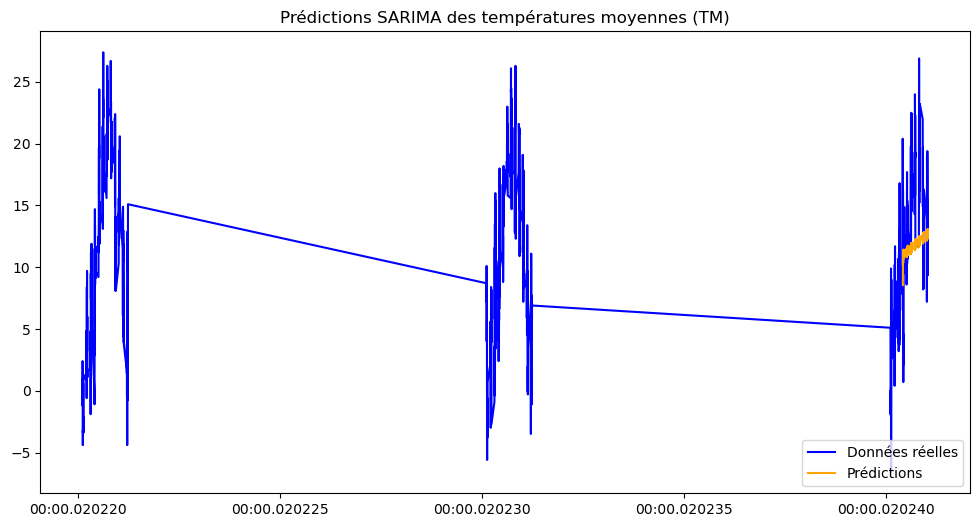

In [27]:
# 7. Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(data_diff, label="Données réelles", color="blue")
plt.plot(forecast_index, forecast_values, label="Prédictions", color="orange")
plt.title("Prédictions SARIMA des températures moyennes (TM)")
plt.legend()
plt.show()